In [1]:
import numpy as np
import torch 

import dataset
import model
import utils

from importlib import reload
reload(utils)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sphereset = dataset.sphere_dataset()

In [5]:
net1 = model.SmallReLU(sphere_dim=500,
                 n_hidden=1000)

### Sanity checks

1. For an arbitrary input, the model should output a number very close to zero, since it's the output of the final linear layer, which should be initialized with mean 0.

In [6]:
#Check for a single input at a time

idx = np.random.randint(0, len(sphereset))
print('Index: {}, Output: {}'.format(idx, net1(sphereset[idx][0])))

Index: 11903741, Output: tensor([0.0021], grad_fn=<SqueezeBackward3>)


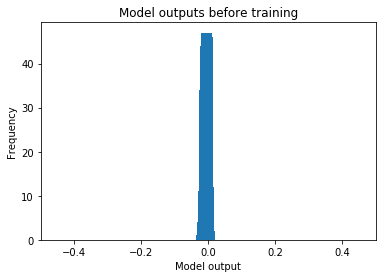

In [7]:
histogram_results = utils.histogram_outputs(net1, 500)
plt.bar(histogram_results[1], histogram_results[0], width = 1./30)
plt.xlabel('Model output')
plt.ylabel('Frequency')
plt.xlim(-0.5,0.5)
plt.title('Model outputs before training');

2. Initially, the accuracy of the model should be a half.

In [8]:
utils.eval_accuracy(net1, n_pts=100)

0.53

## Training time

In [12]:
loss_fun = torch.nn.BCEWithLogitsLoss()

batch_size = 50
dataloader = torch.utils.data.DataLoader(sphereset, 
                                         batch_size=batch_size,
                                         shuffle=False)

optimizer = torch.optim.Adam(net1.parameters(), lr = 0.0001)

net1.train()

losses = []

for i, (points, labels) in enumerate(dataloader):
    
    net1.zero_grad()
    
    output = net1(points)
    
    loss = loss_fun(output, labels.view(-1,1).float())
    loss.backward()
    
    optimizer.step()

    losses.append(loss.item())
    
    if i > 1000:
        break

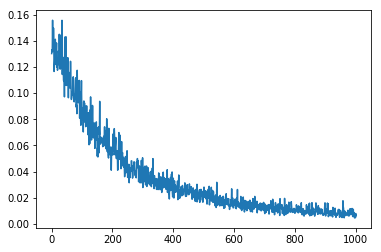

In [13]:
plt.plot(losses)

### More sanity checks

1. Accuracy should be a lot higher than 0.5 now

In [14]:
utils.eval_accuracy(net1, 100000)

0.99999

In [ ]:
0.99999*100000

2. Histogram should reveal two blobs, not one

Text(0.5,1,'Model outputs after training')

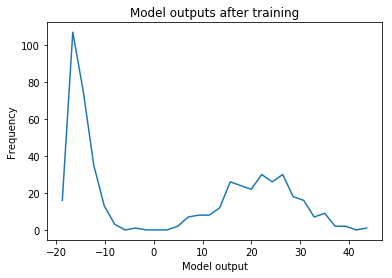

In [50]:
histogram_results = utils.histogram_outputs(net1, 500)
plt.plot(histogram_results[1], histogram_results[0])
plt.xlabel('Model output')
plt.ylabel('Frequency')
plt.title('Model outputs after training')